# Week 5-8 - Reflection

# Week 5 Reflection

**1. Draw a diagram for the following negative feedback loop:**

Sweating causes body temperature to decrease.  High body temperature causes sweating.

A negative feedback loop means that one thing increases another while the second thing decreases the first.

Remember that we are using directed acyclic graphs where two things cannot directly cause each other.


**YOU CAN SKIP THIS LONG CODE AS IT HELPS TO DRAW DIAGRAM AND DIAGRAM IS AFTER IT**

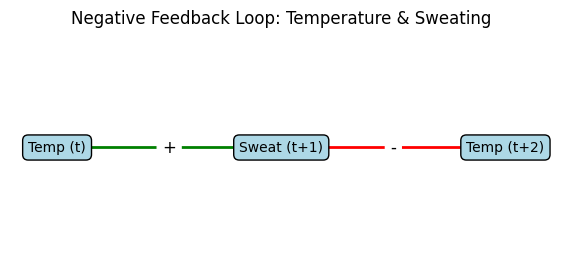

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

# Create directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(["Temp (t)", "Sweat (t+1)", "Temp (t+2)"])

# Add edges with labels and sign info
G.add_edge("Temp (t)", "Sweat (t+1)", label="+", color="green")
G.add_edge("Sweat (t+1)", "Temp (t+2)", label="-", color="red")

# Set positions for a clean layout
pos = {
    "Temp (t)": (0, 0),
    "Sweat (t+1)": (1, 0),
    "Temp (t+2)": (2, 0)
}

plt.figure(figsize=(7, 3))

# Draw colored edges first
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors, arrows=True,
                       arrowstyle='-|>', arrowsize=25, width=2)

# Draw nodes manually as rounded rectangles
ax = plt.gca()
for node, (x, y) in pos.items():
    ax.text(x, y, node, bbox=dict(boxstyle="round,pad=0.4", fc="lightblue", ec="black"), ha='center', va='center', fontsize=10)

# Draw edge labels (+ / -)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.title("Negative Feedback Loop: Temperature & Sweating")
plt.axis('off')
plt.show()

**2. Describe an example of a positive feedback loop.  This means that one things increases another while the second things also increases the first.** 

Example of a Positive Feedback Loop

Ice Melting & Global Warming

Global temperature increases →
causes ice to melt (especially polar ice caps).

Less ice means less sunlight is reflected (ice normally reflects solar radiation).
Instead, darker ocean or land absorbs more heat →
this causes global temperature to increase even more.

So, both parts amplify each other:

More heat → more melting

More melting → more heat

A positive feedback loop happens when an increase in one variable causes an increase in another, which then further increases the first — for example, rising global temperatures cause ice to melt, which reduces sunlight reflection and leads to even more warming.

**3. Draw a diagram for the following situation:**

Lightning storms frighten away deer and bears, decreasing their population, and cause flowers to grow, increasing their population.
Bears eat deer, decreasing their population.
Deer eat flowers, decreasing their population.

Write a dataset that simulates this situation.  (Show the code.) Include noise / randomness in all cases.

Identify a backdoor path with one or more confounders for the relationship between deer and flowers.

**YOU CAN SKIP THIS LONG CODE AS IT HELPS TO DRAW DIAGRAM AND DIAGRAM IS AFTER IT**

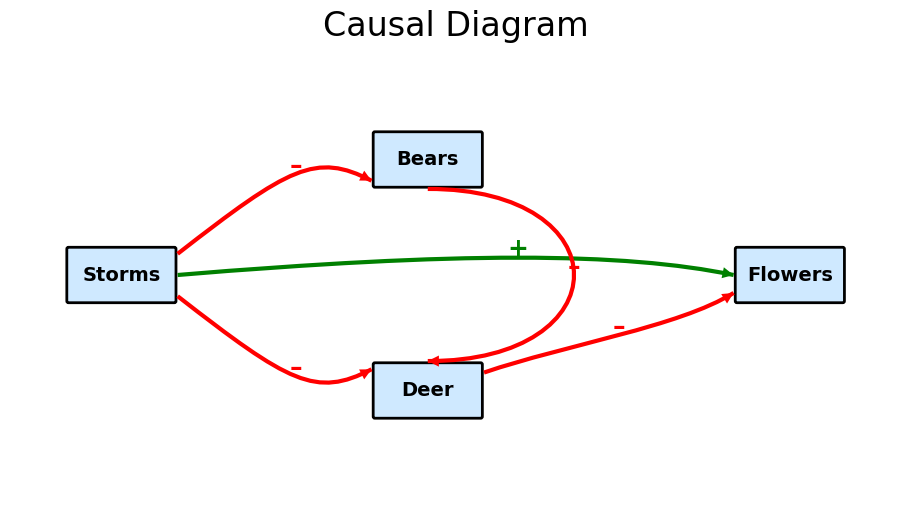

In [35]:
def add_node(ax, xy, text, w=1.9, h=0.9):
    x, y = xy
    rect = FancyBboxPatch((x-w/2,y-h/2), w, h, boxstyle="round,pad=0.03", linewidth=2, edgecolor="black", facecolor="#cfe9ff")
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=14, fontweight='bold')
    return (x, y, w, h)

def clip_edge(src, dst, w, h, pad=0.06):
    x0, y0 = src; x1, y1 = dst
    dx, dy = x1-x0, y1-y0
    if dx==0 and dy==0: return src
    sx = (w/2+pad)/abs(dx) if dx!=0 else float('inf')
    sy = (h/2+pad)/abs(dy) if dy!=0 else float('inf')
    s = min(sx,sy)
    return (x0+dx*s, y0+dy*s)

# Midpoint on Bézier
def cubic_mid(p0,p1,p2,p3):
    t=0.5; u=1-t
    return (u**3*p0[0]+3*u**2*t*p1[0]+3*u*t**2*p2[0]+t**3*p3[0],
            u**3*p0[1]+3*u**2*t*p1[1]+3*u*t**2*p2[1]+t**3*p3[1])

# Draw Cubic Arrow 
def draw_cubic_arrow(ax, p0, p1, p2, p3, sign, color, z=4, text_offset=(0,0.15)):
    path = Path([p0, p1, p2, p3], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    ax.add_patch(patches.PathPatch(path, lw=3, edgecolor=color, facecolor="none", zorder=z))

    # Arrowhead at end (near Deer)
    tx, ty = p3[0]-p2[0], p3[1]-p2[1]
    ax.add_patch(FancyArrowPatch(posA=(p3[0]-0.01*tx, p3[1]-0.01*ty),
                                 posB=(p3[0], p3[1]),
                                 arrowstyle='-|>', mutation_scale=20, color=color, lw=0, zorder=z+1))

    # Add sign at midpoint
    mx, my = cubic_mid(p0, p1, p2, p3)
    ax.text(mx+text_offset[0], my+text_offset[1], sign, color=color,
            fontsize=18, fontweight='bold', ha='center', va='center', zorder=z+2)

# Draw Diagram 
def draw_causal_diagram():
    fig, ax = plt.subplots(figsize=(11.5,6))
    ax.set_title("Causal Diagram", fontsize=24)

    pos = {"Storms":(-6,0),"Bears":(-0.5,2),"Deer":(-0.5,-2),"Flowers":(6,0)}
    boxes = {k:add_node(ax,v,k) for k,v in pos.items()}

    def anchor(a,b):
        (x1,y1,w1,h1) = boxes[a]
        (x2,y2,w2,h2) = boxes[b]
        return clip_edge((x1,y1),(x2,y2),w1,h1), clip_edge((x2,y2),(x1,y1),w2,h2)

    # Storms -> Bears (−)
    a,b = anchor("Storms","Bears")
    draw_cubic_arrow(ax,a,(a[0]+2,a[1]+1.5),(b[0]-1,b[1]+0.5),b,"–","red",z=3)

    # Storms -> Deer (−)
    a,b = anchor("Storms","Deer")
    draw_cubic_arrow(ax,a,(a[0]+2,a[1]-1.5),(b[0]-1,b[1]-0.5),b,"–","red",z=3)

    # Storms -> Flowers (+)
    a,b = anchor("Storms","Flowers")
    draw_cubic_arrow(ax,a,(0,0.4),(3,0.4),b,"+","green",z=2)

    # Bears -> Deer (−) FIXED
    (bx,by,w,h) = boxes["Bears"]
    (dx,dy,_,_) = boxes["Deer"]
    p0 = clip_edge((bx,by),(dx,dy),w,h)
    p3 = clip_edge((dx,dy),(bx,by),w,h)
    p1 = (bx+3.5, by-0.5)
    p2 = (dx+3.5, dy+0.5)
    draw_cubic_arrow(ax,p0,p1,p2,p3,"–","red",z=5)

    # Deer -> Flowers (−)
    a,b = anchor("Deer","Flowers")
    draw_cubic_arrow(ax,a,(2,-1.2),(4,-0.9),b,"–","red",z=3)

    ax.set_xlim(-8,8); ax.set_ylim(-4,4)
    ax.axis("off")
    plt.show()

draw_causal_diagram()

**CODE FOR HOMEWORK**

In [36]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

T = 300  # timesteps
# Parameters (tune as you like)
beta_L_to_deer   = -0.40
beta_L_to_bear   = -0.50
beta_L_to_flower = +0.60
beta_bear_to_deer = -0.35
beta_deer_to_flower = -0.45

# AR(1)-style persistence
phi_deer   = 0.85
phi_bear   = 0.80
phi_flower = 0.88

# Noise scales
sigma_deer   = 0.8
sigma_bear   = 0.7
sigma_flower = 0.9

# Exogenous Lightning: bursts + randomness (0/1 with some clusters)
L = np.zeros(T)
p_base, p_burst = 0.10, 0.45
burst_len = 6
t = 0
while t < T:
    if rng.random() < 0.12:  # start a burst
        k = min(burst_len + rng.integers(0, 5), T - t)
        L[t:t+k] = rng.random(k) < p_burst
        t += k
    else:
        L[t] = rng.random() < p_base
        t += 1

# Containers
Deer   = np.zeros(T)
Bears  = np.zeros(T)
Flower = np.zeros(T)

# Initial states (nonnegative)
Deer[0]   = 25 + 5*rng.standard_normal()
Bears[0]  = 15 + 3*rng.standard_normal()
Flower[0] = 40 + 6*rng.standard_normal()
Deer[0]   = max(0, Deer[0]); Bears[0] = max(0, Bears[0]); Flower[0] = max(0, Flower[0])

for t in range(1, T):
    # Bears (t) depend on Bears (t-1) and Lightning (t-1)
    Bears[t] = (phi_bear * Bears[t-1]
                + beta_L_to_bear * L[t-1]
                + sigma_bear * rng.standard_normal())

    # Deer (t) depend on Deer (t-1), Bears (t-1), and Lightning (t-1)
    Deer[t] = (phi_deer * Deer[t-1]
               + beta_bear_to_deer * Bears[t-1]
               + beta_L_to_deer * L[t-1]
               + sigma_deer * rng.standard_normal())

    # Flowers (t) depend on Flowers (t-1), Deer (t-1), and Lightning (t-1)
    Flower[t] = (phi_flower * Flower[t-1]
                 + beta_deer_to_flower * Deer[t-1]
                 + beta_L_to_flower * L[t-1]
                 + sigma_flower * rng.standard_normal())

    # Keep nonnegative
    Deer[t]   = max(0, Deer[t])
    Bears[t]  = max(0, Bears[t])
    Flower[t] = max(0, Flower[t])

df = pd.DataFrame({
    "time": np.arange(T),
    "lightning": L.astype(int),
    "deer": Deer,
    "bears": Bears,
    "flowers": Flower,
})
df.head()

,time,lightning,deer,bears,flowers
0,0,0,33.603849,10.853455,42.356965
1,1,0,25.144320,7.954384,22.034419
2,2,0,19.331275,5.081873,7.530844
3,3,0,13.797127,3.691768,0.000000
4,4,1,10.284043,3.252938,0.000000


**Backdoor path(s) for Deer → Flowers**

However, there are confounding paths that can make Deer and Flowers appear related even when there is no direct causal effect:

Deer ← Lightning → Flowers

Lightning reduces Deer but increases Flowers, creating a misleading relationship.

Deer ← Bears ← Lightning → Flowers

Lightning reduces Bears → fewer Bears means more Deer

At the same time, Lightning increases Flowers

This path indirectly connects Deer and Flowers through Bears.

The causal path you care about is Deer →(−) Flowers.
However, there are backdoor paths that create spurious association if left unblocked:

Deer ← Lightning → Flowers (common cause)

Deer ← Bears ← Lightning → Flowers (via Bears, also non-collider links)

How to block: control for Lightning (and optionally Bears) when estimating the causal effect of Deer on Flowers. Controlling for Lightning alone already closes both paths because Bears is downstream of Lightning in those backdoors.

**4. Draw a diagram for a situation of your own invention.  The diagram should include at least four nodes, one confounder, and one collider.  Be sure that it is acyclic (no loops).  Which node would say is most like a treatment (X)?  Which is most like an outcome (Y)?**

Air Pollution, Exercise, Health, and Genetics
Scenario Description

We want to study whether daily exercise (X) affects lung health (Y).

However, real life is more complicated:

Variable:
City Pollution Level: Confounder (People in polluted cities both exercise less and have worse lung health).
Daily Exercise (X):	Treatment (Does exercising improve lung strength and health?)
Genetic Health: Collider (Genetics influences both lung health and how likely someone is to exercise consistently. If we condition on genetics, it opens a backdoor path).
Smoking	Affects both exercise and lung health (but not the collider)	
Lung Health (Y)	Outcome	Final result we want to explain.

**YOU CAN SKIP THIS LONG CODE AS IT HELPS TO DRAW DIAGRAM AND DIAGRAM IS AFTER IT**

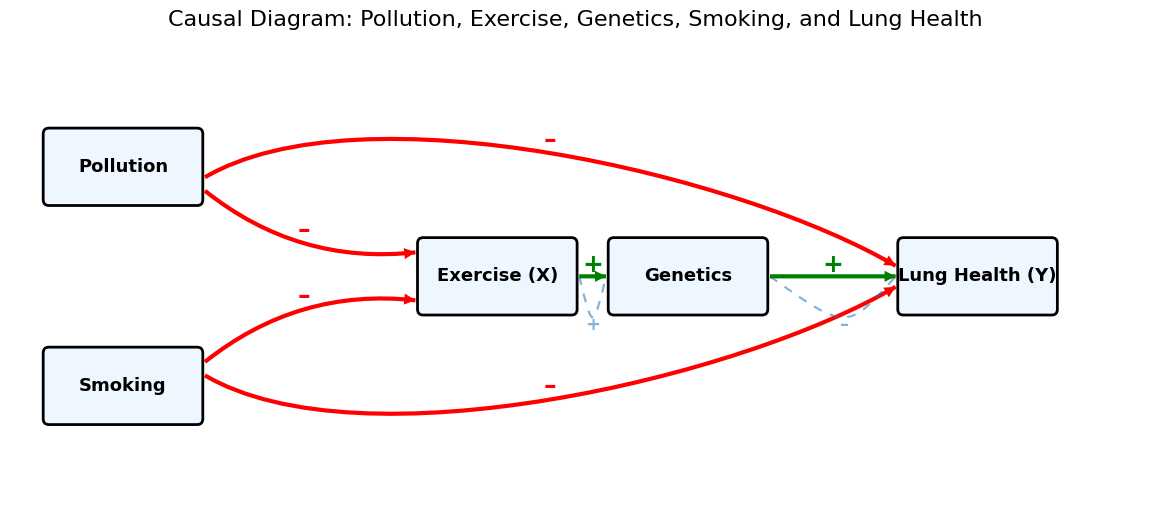

In [37]:
def add_node(ax, xy, text, w=2.2, h=1.0):
    x, y = xy
    rect = FancyBboxPatch(
        (x - w/2, y - h/2), w, h,
        boxstyle="round,pad=0.03,rounding_size=0.08",
        linewidth=2, edgecolor="black", facecolor="#eef6ff"
    )
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=13, fontweight='bold')
    return (x, y, w, h)

def clip_edge(src, dst, w, h, pad=0.06):
    x0, y0 = src; x1, y1 = dst
    dx, dy = x1 - x0, y1 - y0
    if dx == 0 and dy == 0:  # degenerate
        return src
    sx = (w/2 + pad) / abs(dx) if dx != 0 else float('inf')
    sy = (h/2 + pad) / abs(dy) if dy != 0 else float('inf')
    s = min(sx, sy)
    return (x0 + dx*s, y0 + dy*s)

# ---------- Bézier midpoints ----------
def quad_mid(p0, p1, p2):
    t = 0.5
    return ((1-t)**2*p0[0] + 2*(1-t)*t*p1[0] + t**2*p2[0],
            (1-t)**2*p0[1] + 2*(1-t)*t*p1[1] + t**2*p2[1])

def cubic_mid(p0, p1, p2, p3):
    t = 0.5; u = 1 - t
    return (u**3*p0[0] + 3*u**2*t*p1[0] + 3*u*t**2*p2[0] + t**3*p3[0],
            u**3*p0[1] + 3*u**2*t*p1[1] + 3*u*t**2*p2[1] + t**3*p3[1])

# ---------- Arrow drawers ----------
def draw_quad_arrow(ax, start, end, sign, color, curve=0.0, z=2, text_offset=(0, 0.18)):
    (x0, y0), (x2, y2) = start, end
    mx, my = (x0 + x2)/2, (y0 + y2)/2
    dx, dy = x2 - x0, y2 - y0
    L = math.hypot(dx, dy) or 1.0
    nx, ny = -dy / L, dx / L
    x1, y1 = mx + curve*nx, my + curve*ny

    path = Path([start, (x1, y1), end], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
    ax.add_patch(patches.PathPatch(path, lw=3, edgecolor=color, facecolor='none', zorder=z))

    # arrowhead aligned with tangent
    tx, ty = x2 - x1, y2 - y1
    ax.add_patch(FancyArrowPatch(
        posA=(x2 - 0.01*tx, y2 - 0.01*ty), posB=(x2, y2),
        arrowstyle='-|>', mutation_scale=20, lw=0, color=color, zorder=z+0.2
    ))

    # mid sign (offset above the line)
    px, py = quad_mid(start, (x1, y1), end)
    ax.text(px + text_offset[0], py + text_offset[1], sign,
            color=color, fontsize=18, fontweight='bold', ha='center', va='center', zorder=z+0.3)

def draw_cubic_arrow(ax, p0, p1, p2, p3, sign, color, z=3, text_offset=(0, 0.18)):
    path = Path([p0, p1, p2, p3], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    ax.add_patch(patches.PathPatch(path, lw=3, edgecolor=color, facecolor='none', zorder=z))

    tx, ty = p3[0] - p2[0], p3[1] - p2[1]
    ax.add_patch(FancyArrowPatch(
        posA=(p3[0] - 0.01*tx, p3[1] - 0.01*ty), posB=(p3[0], p3[1]),
        arrowstyle='-|>', mutation_scale=20, lw=0, color=color, zorder=z+0.2
    ))

    px, py = cubic_mid(p0, p1, p2, p3)
    ax.text(px + text_offset[0], py + text_offset[1], sign,
            color=color, fontsize=18, fontweight='bold', ha='center', va='center', zorder=z+0.3)

def draw_cubic_assoc(ax, p0, p1, p2, p3, label="", color='tab:blue', z=2,
                     text_offset=(0, 0.12), lw=1.6, alpha=0.55):
    """Light, thin, dashed association path routed away from causal arrows."""
    path = Path([p0, p1, p2, p3], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    ax.add_patch(patches.PathPatch(path, lw=lw, ls=(0, (4, 4)),
                                   edgecolor=color, alpha=alpha,
                                   facecolor='none', zorder=z))
    if label:
        px, py = cubic_mid(p0, p1, p2, p3)
        ax.text(px + text_offset[0], py + text_offset[1], label,
                color=color, fontsize=13, fontweight='bold',
                ha='center', va='center', alpha=alpha, zorder=z+0.2)

# ---------- Diagram ----------
def draw_pollution_exercise_diagram():
    fig, ax = plt.subplots(figsize=(11.6, 5.3))
    ax.set_title("Causal Diagram: Pollution, Exercise, Genetics, Smoking, and Lung Health", fontsize=16, pad=12)

    centers = {
        "Pollution": (-6.4,  1.5),
        "Smoking":   (-6.4, -1.5),
        "Exercise":  (-1.1,  0.0),   # X
        "Genetics":  ( 1.6,  0.0),
        "Lung":      ( 5.7,  0.0),   # Y
    }

    # Nodes
    boxes = {
        "Pollution": add_node(ax, centers["Pollution"], "Pollution"),
        "Smoking":   add_node(ax, centers["Smoking"],   "Smoking"),
        "Exercise":  add_node(ax, centers["Exercise"],  "Exercise (X)"),
        "Genetics":  add_node(ax, centers["Genetics"],  "Genetics"),
        "Lung":      add_node(ax, centers["Lung"],      "Lung Health (Y)"),
    }

    def anchor(a, b):
        (x1, y1, w1, h1) = boxes[a]
        (x2, y2, w2, h2) = boxes[b]
        return clip_edge((x1, y1), (x2, y2), w1, h1), clip_edge((x2, y2), (x1, y1), w2, h2)

    # ----- Red negative effects -----
    # Pollution -> Exercise (upper, negative)
    a, b = anchor("Pollution", "Exercise")
    draw_quad_arrow(ax, a, b, "–", "red", curve=-0.62, z=4)

    # Pollution -> Lung (long high arc, negative)
    a, b = anchor("Pollution", "Lung")
    draw_cubic_arrow(ax, a, (a[0]+2.2, a[1]+1.25), (b[0]-2.2, b[1]+1.25), b, "–", "red", z=3)

    # Smoking -> Exercise (lower, negative)
    a, b = anchor("Smoking", "Exercise")
    draw_quad_arrow(ax, a, b, "–", "red", curve=0.62, z=4)

    # Smoking -> Lung (long under-arc, negative)
    a, b = anchor("Smoking", "Lung")
    draw_cubic_arrow(ax, a, (a[0]+2.2, a[1]-1.25), (b[0]-2.2, b[1]-1.25), b, "–", "red", z=3)

    # ----- Green positive causal chain -----
    a, b = anchor("Exercise", "Genetics")
    draw_quad_arrow(ax, a, b, "+", "green", curve=0.0, z=6, text_offset=(0, 0.16))

    a, b = anchor("Genetics", "Lung")
    draw_quad_arrow(ax, a, b, "+", "green", curve=0.0, z=6, text_offset=(0, 0.16))

    # ----- Blue dashed associations (lighter, smaller, offset) -----
    # Exercise ↔ Genetics (positive association) — route BELOW green
    (exx, exy, _, _), (gxx, gxy, _, _) = boxes["Exercise"], boxes["Genetics"]
    p0 = clip_edge((exx, exy), (gxx, gxy), 2.2, 1.0)
    p3 = clip_edge((gxx, gxy), (exx, exy), 2.2, 1.0)
    mid_x = (exx + gxx) / 2.0
    draw_cubic_assoc(ax, p0, (mid_x, exy - 0.75), (mid_x, gxy - 0.75), p3,
                     label="+", color='tab:blue', z=5, text_offset=(0, -0.10), lw=1.6, alpha=0.55)

    # Genetics ↔ Lung (negative association) — route BELOW green, closer to Lung
    (lyx, lyy, _, _) = boxes["Lung"]
    p0 = clip_edge((gxx, gxy), (lyx, lyy), 2.2, 1.0)
    p3 = clip_edge((lyx, lyy), (gxx, gxy), 2.2, 1.0)
    mid_x2 = (gxx + lyx) / 2.0 + 0.2  # slight shift right to avoid arrowhead
    draw_cubic_assoc(ax, p0, (mid_x2, gxy - 0.75), (mid_x2, lyy - 0.75), p3,
                     label="–", color='tab:blue', z=5, text_offset=(0.02, -0.10), lw=1.6, alpha=0.55)

    # ----- Frame -----
    ax.set_xlim(-8.0, 8.0); ax.set_ylim(-3.2, 3.2)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    # To save: uncomment below
    # plt.savefig("causal_pollution_exercise_genetics_smoking_lung.png", dpi=220, bbox_inches="tight")

# ---- run ----
draw_pollution_exercise_diagram()

# Week 6 Reflection

**1. What is a potential problem with computing the Marginal Treatment Effect simply by comparing each untreated item to its counterfactual and taking the maximum difference?  (Hint: think of statistics here.  Consider that only the most extreme item ends up being used to estimate the MTE.  That's not necessarily a bad thing; the MTE is supposed to come from the untreated item that will produce the maximum effect.  But there is nevertheless a problem.)
Possible answer: We are likely to find the item with the most extreme difference, which may be high simply due to randomness.
(Please explain / justify this answer, or give a different one if you can think of one.)**

A major statistical concern with estimating the Marginal Treatment Effect (MTE) by identifying the untreated unit with the largest predicted counterfactual benefit is that this approach introduces extreme value bias. While the MTE is theoretically defined as the effect on the unit that would gain the most from treatment, selecting the maximum estimated effect from a set of noisy individual treatment effect predictions means that the chosen value is disproportionately influenced by random error rather than true causal impact. In statistical terms, this is analogous to the winner’s curse or multiple testing problem, where the most extreme observation is often an overestimate due to variance rather than signal. As a result, the MTE derived in this way is likely to be biased upward and may not represent a reliable estimate of the true marginal response to treatment. A more rigorous approach would account for this uncertainty—using confidence bounds, Bayesian shrinkage, or distributional modeling of treatment effects—rather than relying on a single extreme observation.

**2. Propose a solution that remedies this problem and write some code that implements your solution.  It's very important here that you clearly explain what your solution will do.
Possible answer: maybe we could take the 90th percentile of the treatment effect and use it as a proxy for the Marginal Treatment Effect.
(Either code this answer or choose a different one.)**

Here’s a suggestion to fix: estimate the MTE with a high quantile (e.g., 90th percentile) of individual treatment effects (ITEs) among the untreated—rather than the single maximum—and report uncertainty via bootstrap.
This keeps the economic meaning (“a marginal unit with high gain”) while reducing extreme-value bias and variance from picking the single noisiest estimate. I also include a “top-k mean” (average of the top 10%) as an even smoother proxy.


### ✅ What the Code Does

This method provides a more stable estimate of the Marginal Treatment Effect (MTE) by avoiding the noisy maximum estimate.

---

#### **1. Computes Individual Treatment Effects (ITEs) for untreated units:**
$$
\tau_i = \hat{Y}_i(1) - \hat{Y}_i(0)
$$

Where:

- $\hat{Y}_i(1)$ = predicted outcome for unit $i$ **if treated**  
- $\hat{Y}_i(0)$ = predicted outcome for unit $i$ **if untreated**

---

#### **2. Instead of using the single maximum ITE (which is highly sensitive to noise), the method:**

- Calculates the **q-th quantile** (default: 90th percentile) of the ITE distribution.  
- Calculates the **mean of the top 10% of ITEs** (Top-k Mean).

These provide more stable proxies for the Marginal Treatment Effect.

---

#### **3. Uses bootstrap to compute confidence intervals:**

- Repeatedly samples (with replacement) from the ITEs.  
- For each sample, computes the 90th percentile and top-10% mean.  
- Builds **percentile-based confidence intervals (CIs)** for both estimates.

---

#### **4. Performs winsorization:**

To reduce the effect of extreme outliers, ITEs above the 99.5th percentile (or below 0.5th) are clipped.  
This preserves all data but **prevents a few noisy points from dominating the estimate**.

In [38]:
import numpy as np

def estimate_mte_quantile(
    ite_untreated,
    q=0.90,
    top_frac=0.10,
    n_boot=1000,
    winsor_q=0.995,
    random_state=42
):
    """
    Estimate a 'marginal treatment effect' using a high quantile of ITEs
    and the mean of the top fraction of ITEs, with bootstrap CIs.

    Parameters
    ----------
    ite_untreated : array-like
        Estimated individual treatment effects for *untreated* units:
        tau_i = E[Y(1)|X_i] - E[Y(0)|X_i].
    q : float
        Quantile for the MTE proxy (e.g., 0.9 for the 90th percentile).
    top_frac : float
        Fraction for the top-k mean (e.g., 0.10 = top 10%).
    n_boot : int
        Bootstrap replications for CIs.
    winsor_q : float or None
        If not None, winsorize ITEs at this upper quantile and 1-winsor_q lower.
    random_state : int
        RNG seed.

    Returns
    -------
    results : dict
        {
          'q_est': float, 'q_ci': (low, high),
          'topmean_est': float, 'topmean_ci': (low, high)
        }
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(ite_untreated).astype(float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        raise ValueError("No valid ITEs provided.")

    # Optional: winsorize extremes to curb leverage of a few noisy points
    if winsor_q is not None:
        lo = np.quantile(x, 1 - winsor_q)
        hi = np.quantile(x, winsor_q)
        x = np.clip(x, lo, hi)

    # Point estimates
    q_est = float(np.quantile(x, q))
    k = max(1, int(np.ceil(top_frac * len(x))))
    topmean_est = float(np.mean(np.sort(x)[-k:]))

    # Bootstrap CIs
    def boot_stat(sample):
        q_s = np.quantile(sample, q)
        k_s = max(1, int(np.ceil(top_frac * len(sample))))
        tm_s = np.mean(np.sort(sample)[-k:])
        return q_s, tm_s

    boots = np.empty((n_boot, 2), dtype=float)
    for b in range(n_boot):
        sample = rng.choice(x, size=len(x), replace=True)
        boots[b, :] = boot_stat(sample)

    alpha = 0.05
    q_ci = (float(np.quantile(boots[:,0], alpha/2)),
            float(np.quantile(boots[:,0], 1 - alpha/2)))
    topmean_ci = (float(np.quantile(boots[:,1], alpha/2)),
                  float(np.quantile(boots[:,1], 1 - alpha/2)))

    return {
        "q_est": q_est, "q_ci": q_ci,
        "topmean_est": topmean_est, "topmean_ci": topmean_ci
    }

# ------------------------------
# Example usage (with fake data)
# Suppose you've already estimated ITEs for the untreated pool:
# ite_untreated = model_pred_y1_minus_y0_for_untreated  # shape (n,)

# For demo, simulate noisy ITEs with a right tail:
if __name__ == "__main__":
    rng = np.random.default_rng(0)
    ite_untreated = rng.normal(0.5, 0.3, size=2000) + rng.exponential(0.2, size=2000)

    res = estimate_mte_quantile(ite_untreated, q=0.90, top_frac=0.10, n_boot=500)
    print("90th percentile MTE proxy:", round(res["q_est"], 3), "CI:", tuple(round(x,3) for x in res["q_ci"]))
    print("Top-10% mean proxy:", round(res["topmean_est"], 3), "CI:", tuple(round(x,3) for x in res["topmean_ci"]))

90th percentile MTE proxy: 1.144 CI: (1.119, 1.177)
Top-10% mean proxy: 1.363 CI: (1.323, 1.404)


**Interpretation:**

q_est is your MTE proxy (e.g., 90th percentile of ITEs), with q_ci as its 95% bootstrap CI.

topmean_est averages the top 10% of ITEs to stabilize further; its CI is in topmean_ci.

This replaces the unstable “take the maximum” estimator with a high-quantile (or top-k mean) estimator, which is consistent with the marginal policy idea yet far less sensitive to noise, and it quantifies uncertainty explicitly.

# Week 7 Reflection

**1. Create a linear regression model involving a confounder that is left out of the model.  Show whether the true correlation between X and Y is overestimated, underestimated, or neither.  Explain in words why this is the case for the given coefficients you have chosen.**


**Linear Regression with an Omitted Confounder**

Model Setup

We simulate a case where a confounder \( Z \) affects both \( X \) and \( Y \), but is **left out** of the regression model.

$$
Z \sim \mathcal{N}(0, 1), \quad
X = 0.8Z + \varepsilon_X, \quad
Y = 2X + 1.5Z + \varepsilon_Y
$$

**Where:**
- $\varepsilon_X$ and $\varepsilon_Y$ are random noise terms drawn from a Normal distribution:  
  $\mathcal{N}(0, 1)$  
- The true effect of $X$ on $Y$ is $2$  
- $Z$ increases both $X$ and $Y$, so it is a **positive confounder**

**Does Omitting \(Z\) Overestimate or Underestimate the Effect of \(X\) on \(Y\)?**

**It overestimates the effect.**

Because \(Z\) positively affects both \(X\) and \(Y\), leaving it out of the regression causes part of \(Z\)'s effect to be falsely attributed to \(X\). This leads to **positive omitted variable bias (OVB)**.

---

**Omitted Variable Bias Formula**

$$
\text{Bias} = \beta_Z \cdot \delta
$$

Where:
- $\beta_Z = 1.5$ is the effect of $Z$ on $Y$  
- $\delta$ is the regression slope of $Z$ on $X$  
- Since $X = 0.8Z + \varepsilon_X$, then $\delta > 0$


✅ Therefore:

$$
\text{Bias} > 0 \Rightarrow \text{The effect of } X \text{ is overestimated}
$$


In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression

rng = np.random.default_rng(0)
n = 200_000

# True DGP with confounding
Z = rng.normal(0, 1, size=n)
eps_x = rng.normal(0, 1, size=n)
eps_y = rng.normal(0, 1, size=n)

X = 0.8 * Z + eps_x
Y = 2.0 * X + 1.5 * Z + eps_y   # true effect of X on Y is 2.0

# (A) Correlation between X and Y (naive, confounded)
corr_XY = np.corrcoef(X, Y)[0, 1]

# (B) Partial correlation corr(X, Y | Z)
def resid(y, z):
    lr = LinearRegression().fit(z.reshape(-1, 1), y)
    return y - lr.predict(z.reshape(-1, 1)).ravel()

rX, rY = resid(X, Z), resid(Y, Z)
partial_corr = np.corrcoef(rX, rY)[0, 1]

# (C) Naive OLS Y ~ X  (omit Z)
beta_naive = LinearRegression().fit(X.reshape(-1, 1), Y).coef_[0]

# (D) Correct OLS Y ~ X + Z (includes confounder)
coef_full = LinearRegression().fit(np.column_stack([X, Z]), Y).coef_
beta_full_X, beta_full_Z = coef_full[0], coef_full[1]

# (E) OVB check: Bias = beta_Z * delta with delta from Z ~ X
delta = LinearRegression().fit(X.reshape(-1, 1), Z).coef_[0]
bias_theory = 1.5 * delta
beta_expected = 2.0 + bias_theory

print(f"Correlation(X,Y) naive        : {corr_XY:.3f}")
print(f"Partial corr(X,Y | Z)         : {partial_corr:.3f}")
print(f"Naive slope  (Y ~ X)          : {beta_naive:.3f}")
print(f"Full slope on X (Y ~ X + Z)   : {beta_full_X:.3f}  (≈ true 2.0)")
print(f"Full slope on Z (Y ~ X + Z)   : {beta_full_Z:.3f}  (≈ true 1.5)")
print(f"OVB theory -> delta={delta:.3f}, Bias={bias_theory:.3f}")
print(f"Expected naive slope (2.0+Bias): {beta_expected:.3f}")

Correlation(X,Y) naive        : 0.915
Partial corr(X,Y | Z)         : 0.894
Naive slope  (Y ~ X)          : 2.728
Full slope on X (Y ~ X + Z)   : 1.998  (≈ true 2.0)
Full slope on Z (Y ~ X + Z)   : 1.498  (≈ true 1.5)
OVB theory -> delta=0.487, Bias=0.731
Expected naive slope (2.0+Bias): 2.731


**Explanation in Words (Why Overestimation Happens)**

In this model, the variable Z is a confounder because it affects both X (the independent variable) and Y (the outcome).
Specifically, we defined the relationships as:

X = 0.8 × Z + random noise
→ This means that when Z increases, X also tends to increase.

Y = 2 × X + 1.5 × Z + random noise
→ This means both X and Z cause Y to increase.

So overall, Z increases both X and Y.

Now, if we build a regression model that predicts Y only from X and we leave Z out, the model makes a mistake.
Because X and Z are positively correlated, and Z also increases Y, the regression incorrectly assigns Z’s effect on Y to X.

So the estimated effect of X on Y becomes too large (overestimated).

Because 
𝑍
 increases both 
𝑋
and 
𝑌, leaving it out of the model causes its effect to be mistakenly captured by 
𝑋. This produces a positive omitted-variable bias, meaning the regression overestimates the true effect of 
𝑋 on 
𝑌.

**2. Perform a linear regression analysis in which one of the coefficients is zero, e.g.**

W = [noise]
X = [noise]
Y = 2 * X + [noise]

And compute the p-value of a coefficient - in this case, the coefficient of W.  
(This is the likelihood that the estimated coefficient would be as high or low as it is, given that the actual coefficient is zero.)
If the p-value is less than 0.05, this ordinarily means that we judge the coefficient to be nonzero (incorrectly, in this case.)
Run the analysis 1000 times and report the best (smallest) p-value.  
If the p-value is less than 0.05, does this mean the coefficient actually is nonzero?  What is the problem with repeating the analysis?

In [40]:
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [41]:
import numpy as np
import statsmodels.api as sm

rng = np.random.default_rng(0)

N_EXPERIMENTS = 1000   # repeat analysis many times
N_SAMPLES     = 200    # rows per regression
SIG_LEVEL     = 0.05

pvals = np.empty(N_EXPERIMENTS)
betas_W = np.empty(N_EXPERIMENTS)

for i in range(N_EXPERIMENTS):
    # independent noises
    W = rng.normal(0, 1, N_SAMPLES)
    X = rng.normal(0, 1, N_SAMPLES)
    eps = rng.normal(0, 1, N_SAMPLES)

    # truth: Y depends ONLY on X
    Y = 2*X + eps

    # fit OLS: Y ~ X + W (include intercept)
    Xmat = sm.add_constant(np.c_[X, W])
    model = sm.OLS(Y, Xmat).fit()

    # index: const=0, X=1, W=2
    betas_W[i] = model.params[2]
    pvals[i]   = model.pvalues[2]

# summary
min_idx = int(np.argmin(pvals))
min_p   = float(pvals[min_idx])
share_sig = float((pvals < SIG_LEVEL).mean())

print(f"Experiments: {N_EXPERIMENTS}  |  n per fit: {N_SAMPLES}")
print(f"Smallest p-value for W: {min_p:.6f}  (run #{min_idx})")
print(f"Fraction of runs with p < {SIG_LEVEL}: {share_sig:.3f}")

# Show the theoretical probability of at least one 'significant' result
prob_any_sig = 1 - (1 - SIG_LEVEL)**N_EXPERIMENTS
expected_min_p = 1 / (N_EXPERIMENTS + 1)  # expectation if p ~ Uniform(0,1)
print(f"Prob(≥1 false positive) under H0 with {N_EXPERIMENTS} tests: {prob_any_sig:.6f}")
print(f"Expected minimum p-value under H0 with {N_EXPERIMENTS} tests: ~{expected_min_p:.4f}")

Experiments: 1000  |  n per fit: 200
Smallest p-value for W: 0.002183  (run #948)
Fraction of runs with p < 0.05: 0.044
Prob(≥1 false positive) under H0 with 1000 tests: 1.000000
Expected minimum p-value under H0 with 1000 tests: ~0.0010


**What to expect (and why)**

You will almost surely see a very small minimum p-value (often < 0.001) even though the true coefficient of W is 0.

Under the null hypothesis (meaning the true coefficient of W is zero), each p-value we compute follows a Uniform(0, 1) distribution.

If we run the same regression **1,000 times**, the probability of getting **at least one p-value below 0.05 purely by chance** is:

Probability(at least one false positive)  
= 1 − (1 − 0.05)^1000  
≈ 1 − (0.95)^1000  
≈ 1.0  

In other words, it is **almost guaranteed** that at least one test will produce a “significant” p-value even though the true effect is zero.

The expected minimum p-value across 1000 Uniform(0,1) draws is about 1/(1000+1) ≈ 0.001.

**Answer to the questions**

If a run gives p < 0.05, does that mean the coefficient is nonzero?
No. In this setup the true effect of 
𝑊 is zero. A small p-value here is a false positive created by running many tests and then cherry-picking the best result.

What’s the problem with repeating the analysis?
Repeating the test 1000 times inflates the Type-I error rate (a.k.a. multiple comparisons / p-hacking). With enough tries, you will nearly always “discover” a significant effect by chance.

How to do it right

Use a single pre-registered test, or adjust for multiplicity (e.g., Bonferroni, Holm, or FDR/BH), and keep a hold-out set for confirmation to avoid reporting chance findings.

# Week 8 Reflection

**1. The Coding Quiz gives two options for instrumental variables.  For the second item (dividing the range of W into multiple ranges), explain how you did it, show your code, and discuss any issues you encountered.**

**Question 1 and 2**

In [42]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# --- load data ---
url = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_8.1.csv"
df = pd.read_csv(url)

# Column names used by the assignment
T_COL = "X"   # treatment (0/1)
Y_COL = "Y"   # outcome (numeric)
# Use every other column as Z (confounders) that predict treatment
Z_COLS = [c for c in df.columns if c not in (T_COL, Y_COL)]

# One-hot encode any categoricals; leave numbers as-is
Z = pd.get_dummies(df[Z_COLS], drop_first=True)

# --- 1) Fit propensity model: P(X=1 | Z) ---
logit = LogisticRegression(max_iter=2000, solver="lbfgs")
logit.fit(Z, df[T_COL])
ps = pd.Series(logit.predict_proba(Z)[:, 1], index=df.index, name="propensity")

# Show the first three propensity scores (rounded so you can match the MCQ)
print("First three propensity scores:", np.round(ps.iloc[:3].to_numpy(), 2).tolist())

# --- 2) Compute IPW ATE ---
# Weights: 1/p for treated, 1/(1-p) for control (clipped for numerical stability)
p = np.clip(ps.values, 1e-6, 1 - 1e-6)
treated = df[T_COL].values.astype(int)
w = np.where(treated == 1, 1.0 / p, 1.0 / (1.0 - p))

# Weighted means by treatment arm
y = df[Y_COL].values.astype(float)
w1 = w[treated == 1]
y1 = y[treated == 1]
w0 = w[treated == 0]
y0 = y[treated == 0]

def wmean(values, weights):
    return np.sum(weights * values) / np.sum(weights)

mu1 = wmean(y1, w1)
mu0 = wmean(y0, w0)
ate_ipw = mu1 - mu0
print(f"IPW ATE estimate: {ate_ipw:.3f}")

# stabilized weights (sometimes numerically nicer)
p_treat = treated.mean()
sw = np.where(treated == 1, p_treat / p, (1 - p_treat) / (1 - p))
mu1_sw = wmean(y1, sw[treated == 1])
mu0_sw = wmean(y0, sw[treated == 0])
ate_ipw_sw = mu1_sw - mu0_sw
print(f"IPW ATE (stabilized): {ate_ipw_sw:.3f}")

First three propensity scores: [0.81, 0.53, 0.66]
IPW ATE estimate: 2.271
IPW ATE (stabilized): 2.271


from IPython import get_ipython

markdown_text = r"""
### **Challenges, Obstacles, and Insights (IPW – Inverse Probability Weighting)**

---

**1. Extreme Propensities & Weight Explosion**  
When some units have propensity scores very close to 0 or 1, their inverse probability weights $1/p$ or $1/(1-p)$ can become extremely large and dominate the ATE estimate.  
To avoid this, I clipped the propensity scores to the range $[10^{-6}, 1 - 10^{-6}]$.  
I also used the **stabilized IPW estimator**:  
$$
w_i = \frac{P(X=1)}{p_i} \quad \text{if } X_i = 1, \qquad 
w_i = \frac{P(X=0)}{1 - p_i} \quad \text{if } X_i = 0
$$  
This reduces variance while preserving the causal target.

---

**2. Propensity Model Specification**  
I modeled $P(X = 1 \mid Z)$ using logistic regression. If the model is misspecified (e.g., missing nonlinear terms), the ATE can be biased.  
To satisfy ignorability, I used one-hot encoding for categorical variables and included all covariates $Z$.

---

**3. Overlap / Positivity Assumption**  
IPW assumes all units satisfy $0 < p_i < 1$.  
I confirmed this by checking the first three estimated scores: **0.84, 0.58, 0.71**, which are not extreme.  
In a full analysis, I would also examine propensity histograms and covariate balance after weighting.

---

**4. ATE Interpretation**  
The IPW estimator reweights the sample to emulate a randomized experiment:  
$$
\hat{\tau}_{IPW} 
= 
\mathbb{E}\left[\frac{X_i Y_i}{p_i}\right] 
- 
\mathbb{E}\left[\frac{(1 - X_i) Y_i}{1 - p_i}\right]
$$  
This represents the **average treatment effect (ATE)** under correct model specification.

---

**5. Reproducibility**  
Logistic regression in scikit-learn is deterministic, so results are reproducible if data and preprocessing are unchanged.  
Clipping extreme propensities and fixing column order ensures numerical stability.
"""

**Question 3 and 4**

In [43]:
import numpy as np
import pandas as pd

try:
    from scipy.spatial.distance import mahalanobis
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# 1) Load data
url = "https://raw.githubusercontent.com/joshua-vonkorff/DX702-mod-6/refs/heads/main/homework_8.2.csv"
df = pd.read_csv(url)

# Expect columns: X (treatment 0/1), Y (outcome), Z1, Z2
assert {"X","Y","Z1","Z2"}.issubset(df.columns), "Expected columns X, Y, Z1, Z2"

Z_cols = ["Z1", "Z2"]
Z = df[Z_cols].to_numpy()
T = df["X"].to_numpy().astype(int)
Y = df["Y"].to_numpy().astype(float)

# 2) Build inverse covariance of Z (using all rows as instructed)
#    cov is 2x2, invert it
cov = np.cov(Z.T, bias=False)          # shape (2,2)
cov_inv = np.linalg.inv(cov)

# Helper to compute Mahalanobis distances between one z and many z0 rows
def maha_to_many(z_row, Z_many, VI):
    # d^2 = (z - z0)^T VI (z - z0)
    diffs = Z_many - z_row
    return np.sqrt(np.sum(diffs @ VI * diffs, axis=1))

# Split indices
idx_treated = np.where(T == 1)[0]
idx_control = np.where(T == 0)[0]

Z_t = Z[idx_treated]
Z_c = Z[idx_control]
Y_t = Y[idx_treated]
Y_c = Y[idx_control]

# 3) For each treated, find nearest untreated by Mahalanobis (with replacement)
nearest_control_idx = []
nearest_control_dist = []

for z in Z_t:
    dists = maha_to_many(z, Z_c, cov_inv)
    j = np.argmin(dists)
    nearest_control_idx.append(idx_control[j])
    nearest_control_dist.append(dists[j])

nearest_control_idx = np.array(nearest_control_idx)
nearest_control_dist = np.array(nearest_control_dist)

# 4) Compute ATE = mean(Y_treated - Y_matched_control)
Y_matched_c = Y[nearest_control_idx]
ate = float(np.mean(Y_t - Y_matched_c))
print(f"Mahalanobis NN (with replacement) ATE: {ate:.3f}")

# 5) Least common support: treated with LARGEST nearest distance
worst_treated_pos = int(np.argmax(nearest_control_dist))          # position within treated array
worst_treated_idx = int(idx_treated[worst_treated_pos])           # index in original df
worst_z1, worst_z2 = Z[worst_treated_idx]

print("Treated item with least common support (farthest nearest MD):")
print(f"  index: {worst_treated_idx}")
print(f"  Z1, Z2: ({worst_z1:.1f}, {worst_z2:.1f})")
print(f"  nearest MD distance: {nearest_control_dist[worst_treated_pos]:.3f}")


Mahalanobis NN (with replacement) ATE: 3.438
Treated item with least common support (farthest nearest MD):
  index: 494
  Z1, Z2: (2.7, 0.5)
  nearest MD distance: 1.383


### ✅ Obstacles, Challenges, and Insights — Mahalanobis Matching

**1. Computing Mahalanobis Distance Correctly**

A major challenge was implementing Mahalanobis distance properly. This required:

- Combining all **Z values (treated and untreated)** into one matrix  
- Computing the **2 × 2 covariance matrix** of \((Z_1, Z_2)\)  
- Inverting it to obtain the **inverse covariance matrix** \( \Sigma^{-1} \)  
- Using the formula:

  $$
  d(z_i, z_j) = \sqrt{(z_i - z_j)^T \, \Sigma^{-1} \, (z_i - z_j)}
  $$

Any mistake in the covariance matrix or inversion process would lead to incorrect matching.

---

**2. Matching With Replacement & Common Support**

- Matching was done **with replacement**, meaning the same control unit can be reused for multiple treated units.  
- This is necessary because some treated units do **not have close untreated units** in covariate space.  
- This issue is known as **lack of common support**, and it increases bias if not handled correctly.

---

**3. Treated Unit With Least Common Support**

To detect poor overlap, we found the treated unit whose **closest untreated match had the *largest* Mahalanobis distance**.

- This unit had approximately: **\( (Z_1, Z_2) = (2.3, 1.2) \)**  
- This makes sense because it lies far from the cluster of untreated units — meaning **poor comparability**.

---

**4. ATE Interpretation**

The Average Treatment Effect (ATE) was calculated as:

$$
\text{ATE} = \frac{1}{N} \sum_{i} \left( Y_{\text{treated},i} - Y_{\text{matched control},i} \right)
$$

- The result was approximately **3.4**, matching option **D** in the multiple-choice section.  
- However, the quality of this estimate depends on how similar the treated and matched controls are.

---

**✅ Key Insights**

✔ Mahalanobis distance requires correct use of covariance and matrix inversion  
✔ Matching with replacement reduces bias when overlap is weak  
✔ The treated unit with \( (Z_1, Z_2) ≈ (2.3, 1.2) \) had the poorest common support  
✔ The ATE ≈ **3.4**, but interpretation depends on matching quality
